# Chapter II - International Trade Networks and World Trade Web

## Downloading the datasets from Comtrade
### Starting from the [Comtrade](http://comtrade.un.org/) web site it is possible to download the datasets related to the International Trade.
### FStarting from the [Express Selection](http://comtrade.un.org/db/dqQuickQuery.aspx) ([instructions](http://unstats.un.org/unsd/tradekb/Knowledgebase/How-to-use-the-Express-Selection-feature-in-the-Data-Query)) interface that you can reach through the path: 
* comtrade.un.org/Legacy Annual 
* data/Data Query/Express Selection

### it is possible to get Comtrade data related to 'Total' transactions ('Import' and 'Export') among 'All' countries for a specific year, in our case 2003.
### (for specific products, instead of total put the code. For example 93 for Arms)

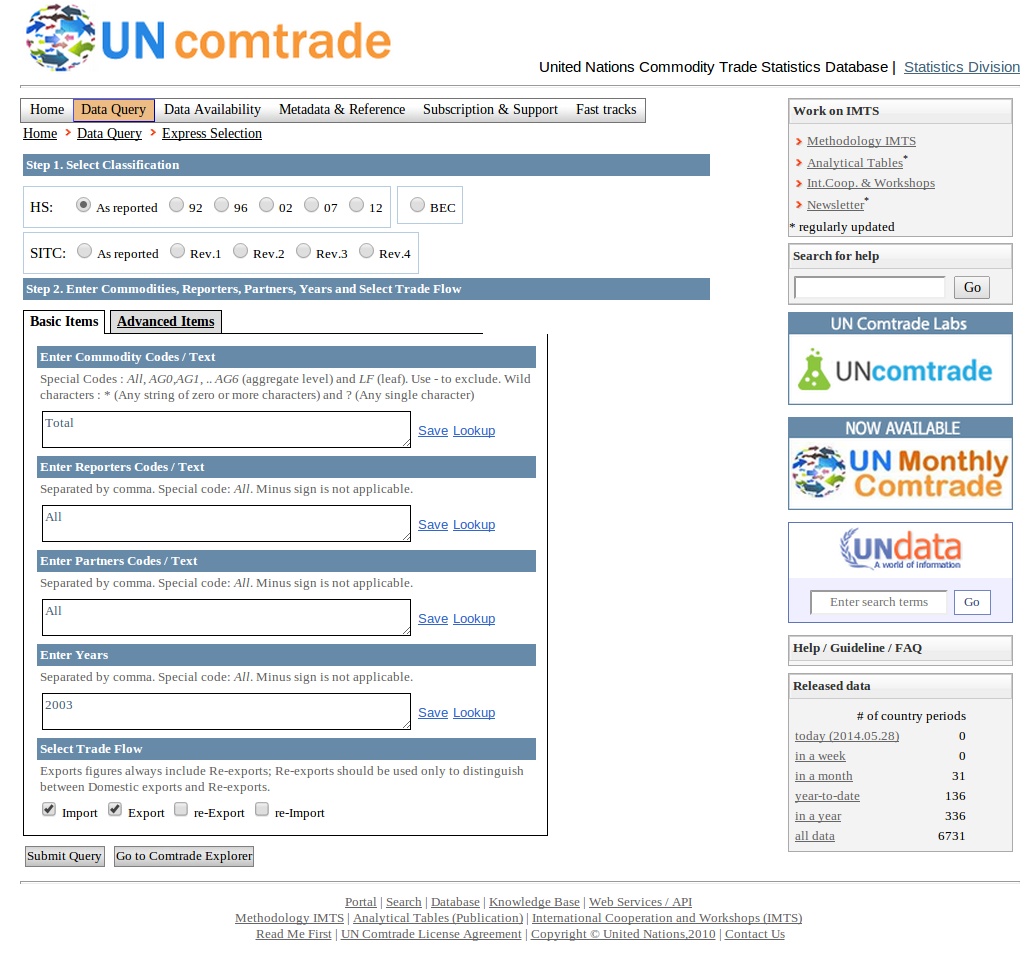

In [1]:
from IPython.display import Image
Image(filename='figs/comtrade_query_interface.png')

### From the download page you can get the CSV file with all the data through the link 'Direct Download'

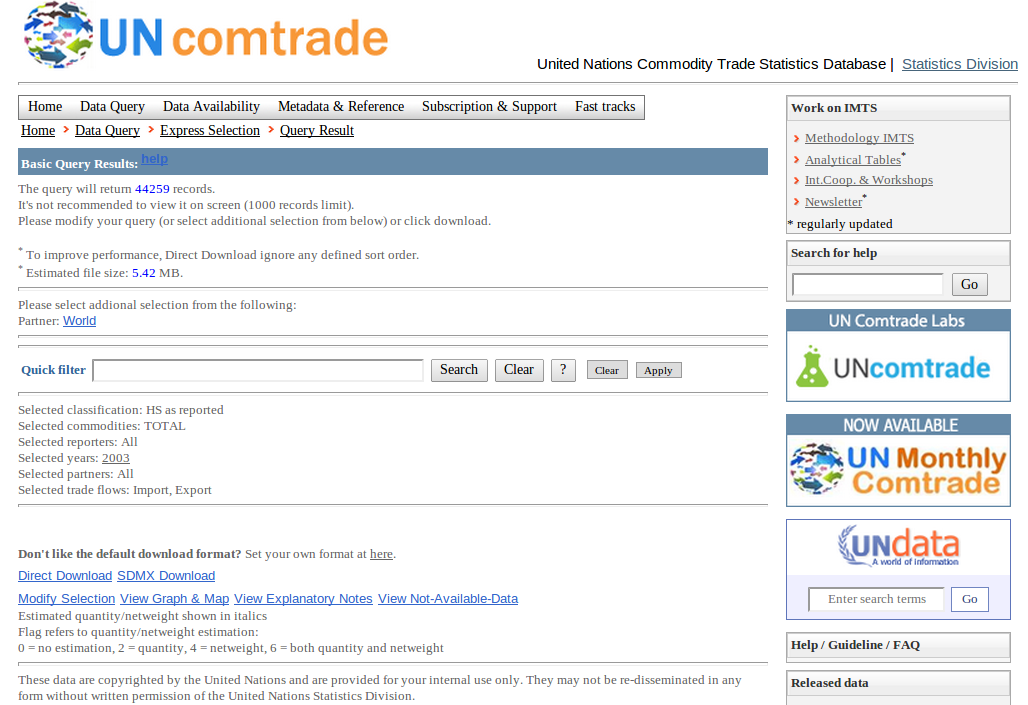

In [2]:
Image(filename='figs/comtrade_download_page.png')

### Here is the data files downloaded (the aggregate and the products category used for the examples in the book)

In [3]:
!ls data/comtrade_trade*

data/comtrade_trade_data_2003_product_09.csv
data/comtrade_trade_data_2003_product_10.csv
data/comtrade_trade_data_2003_product_27.csv
data/comtrade_trade_data_2003_product_29.csv
data/comtrade_trade_data_2003_product_30.csv
data/comtrade_trade_data_2003_product_39.csv
data/comtrade_trade_data_2003_product_52.csv
data/comtrade_trade_data_2003_product_71.csv
data/comtrade_trade_data_2003_product_72.csv
data/comtrade_trade_data_2003_product_84.csv
data/comtrade_trade_data_2003_product_85.csv
data/comtrade_trade_data_2003_product_87.csv
data/comtrade_trade_data_2003_product_90.csv
data/comtrade_trade_data_2003_product_93.csv
data/comtrade_trade_data_total_2003.csv


### check the data file

In [4]:
!head data/comtrade_trade_data_2003_product_09.csv

## Special 'Countiries' to be exluded when loading data

* 472	Africa CAMEU region, nes
* 899	Areas, nes
* 471	CACM, nes
* 129	Caribbean, nes
* 221	Eastern Europe, nes
* 97	 EU-27
* 697	Europe EFTA, nes
* 492	Europe EU, nes
* 838	Free Zones
* 473	LAIA, nes
* 536	Neutral Zone
* 637	North America and Central America, nes
* 290	Northern Africa, nes
* 527	Oceania, nes
* 577	Other Africa, nes
* 490	Other Asia, nes
* 568	Other Europe, nes
* 636	Rest of America, nes
* 839	Special Categories
* 879	Western Asia, nes
* 0      World


## Network Symmetrisation

In [5]:
def net_symmetrisation(wtn_file, exclude_countries):
    DG=nx.DiGraph()
    
    Reporter_pos=1
    Partner_pos=3
    Flow_code_pos=2
    Value_pos=9
    
    dic_trade_flows={}
    hfile=open(wtn_file,'r')
    
    header=hfile.readline()
    lines=hfile.readlines()
    for l in lines:
        l_split=l.split(',')
        #the following is to prevent parsing lines without data
        if len(l_split)<2: continue 
        reporter=int(l_split[Reporter_pos])
        partner=int(l_split[Partner_pos])
        flow_code=int(l_split[Flow_code_pos])
        value=float(l_split[Value_pos])
        
        if ( (reporter in exclude_countries) or \
            (partner in exclude_countries) or (reporter==partner) ): 
            continue
        
        if flow_code==1 and value>0.0:
            #1=Import, 2=Export
            if dic_trade_flows.has_key((partner,reporter,2)): 
                DG[partner][reporter]['weight']= \
                (DG[partner][reporter]['weight']+value)/2.0
            else:
                DG.add_edge(partner, reporter, weight=value)
                dic_trade_flows[(partner,reporter,1)]= \
                value #this is to mark the exixtence of the link
        
        elif flow_code==2 and value>0.0:
            #1=Import, 2=Export
            if dic_trade_flows.has_key((reporter,partner,1)): 
                DG[reporter][partner]['weight']= \
                (DG[reporter][partner]['weight']+value)/2.0
            else:
                DG.add_edge(reporter, partner, weight=value)
                #this is to mark the exixtence of the link
                dic_trade_flows[(reporter,partner,2)]=value 
        else:
            print "trade flow not present\n"
        
    hfile.close()
    
    return DG

## Generate the aggregate network

In [7]:
#importing the main modules

import networkx as nx

#countries to be excluded
exclude_countries=[472,899,471,129,221,97,697,492,838,473,536,\
637,290,527,577,490,568,636,839,879,0]

#this is the magic command to have the graphic embedded 
#in the notebook
%pylab inline 

DG=net_symmetrisation("data/comtrade_trade_data_total_2003.csv", \
                      exclude_countries)
print "number of nodes", DG.number_of_nodes()
print "number of edges", DG.number_of_edges()


Populating the interactive namespace from numpy and matplotlib
number of nodes 232
number of edges 27901


## Reciprocity

We can define both the reciprocity in the unweighted case as: 
$$r=\frac{L^\leftrightarrow}{L}$$
where $${L^\leftrightarrow}$$ is the number of reciprocated links that for a connected network ammounts to $$2L-N(N-1)$$


In [9]:
#unweighted case
N=DG.number_of_nodes()
L=DG.number_of_edges()

r=float((2*L-N*(N-1)))/L

print r

0.079208630515


In the weighted case the formula changes in:
$$r=\frac{W^\leftrightarrow}{W}$$
where $$W^\leftrightarrow=\sum_i\sum_{j\neq i}w^\leftrightarrow_{ij}$$ is the sum of the reciprocated weights with $$w^\leftrightarrow_{ij}=min[w_{ij},w_{ji}]=w^\leftrightarrow_{ji}$$
and $$W=\sum_i\sum_{j\neq i}w_{ij}$$

In [10]:
#weighted case
W=0
W_rep=0
for n in DG.nodes():
    for e in DG.out_edges(n,data=True):
        W+=e[2]['weight']
        if DG.has_edge(e[1],e[0]):
            W_rep+=min(DG[e[0]][e[1]]['weight'],DG[e[1]][e[0]] \
                       ['weight'])
            
print W,W_rep,W_rep/W 

7.17766475925e+12 5.19627606057e+12 0.723950788293


## Assortativity

(array([ 26.,  18.,  22.,  33.,  31.,  33.,  33.,  21.,  11.,   2.,   1.,
          1.]),
 array([ 244.2079646 ,  259.44063422,  274.67330383,  289.90597345,
         305.13864307,  320.37131268,  335.6039823 ,  350.83665192,
         366.06932153,  381.30199115,  396.53466077,  411.76733038,  427.        ]),
 <a list of 12 Patch objects>)

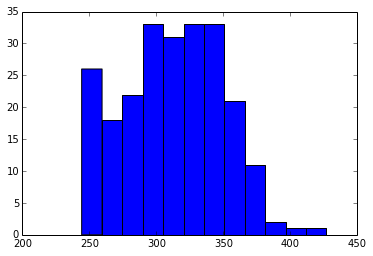

In [11]:
#K_nn distribution
list_Knn=[]
for n in DG.nodes():
    degree=0.0
    for nn in DG.neighbors(n):
        degree=degree+DG.degree(nn)
    list_Knn.append(degree/len(DG.neighbors(n)))

#plot the histogram    
hist(list_Knn,bins=12)

In [12]:
#basic Pearson correlation coefficient for the
r=nx.degree_assortativity_coefficient(DG)
print r

-0.335002643638


### to compute the weighted version of the assortativity Networkx has extra parameters and also the possibility to decide for 'out' or 'in' degree correlations both for the source and target nodes (the default is x='out',y='in')

In [13]:
#weighted version
r=nx.degree_pearson_correlation_coefficient(DG,weight='weight', \
                                            x='out',y='out')
print r

-0.0696781960521


## Density and Strength (in and out)

### Loadging product Networks

In [18]:
dic_product_netowrks={}
commodity_codes=['09','10','27','29','30','39','52','71','72','84', \
'85','87','90','93']
for c in commodity_codes:
    dic_product_netowrks[c]=net_symmetrisation( \
    "data/comtrade_trade_data_2003_product_"+c+".csv", \
    exclude_countries)
    
DG_aggregate=net_symmetrisation( \
"data/comtrade_trade_data_total_2003.csv",exclude_countries)

### rescale the weighted ajacency aggregate matrix
$$w_{ij}^{tot}=\frac{ w_{ij}^{tot} }{ \sum_{hk}w_{hk}^{tot} }$$

In [19]:
w_tot=0.0
for u,v,d  in DG_aggregate.edges(data=True):
    w_tot+=d['weight']
for u,v,d  in DG_aggregate.edges(data=True):
    d['weight']=d['weight']/w_tot

### rescale the weighted ajacency product matrices
$$w_{ij}^c=\frac{w_{ij}^c}{\sum_{hk}w_{hk}^c}$$

In [20]:
for c in commodity_codes:
    l_p=[]
    w_tot=0.0
    for u,v,d  in dic_product_netowrks[c].edges(data=True):
        w_tot+=d['weight']
    for u,v,d  in dic_product_netowrks[c].edges(data=True):
        d['weight']=d['weight']/w_tot

### Generate the table with the quantities
$$Density\   w_{ij}\  NS_{in}/ND_{in}\  NS_{out}/ND_{out}$$

In [21]:
density_aggregate=DG_aggregate.number_of_edges() / \
(DG_aggregate.number_of_nodes()*(DG_aggregate.number_of_nodes()-1.0))

w_agg=[]
NS_in=[]
NS_out=[]
for u,v,d in DG_aggregate.edges(data=True):
    w_agg.append(d['weight'])
for n in DG_aggregate.nodes():
    if DG_aggregate.in_degree(n)>0:
        NS_in.append(DG_aggregate.in_degree(n,weight='weight')/ \
                     DG_aggregate.in_degree(n))
    if DG_aggregate.out_degree(n)>0:
        NS_out.append(DG_aggregate.out_degree(n,weight='weight')/ \
                      DG_aggregate.out_degree(n))
    
for c in commodity_codes:
    density_commodity=dic_product_netowrks[c].number_of_edges() / \
    (dic_product_netowrks[c].number_of_nodes()* \
    (dic_product_netowrks[c].number_of_nodes()-1.0))
    w_c=[]
    NS_c_in=[]
    NS_c_out=[]
    for u,v,d  in dic_product_netowrks[c].edges(data=True):
        w_c.append(d['weight'])
    for n in dic_product_netowrks[c].nodes():
        if dic_product_netowrks[c].in_degree(n)>0:
            NS_c_in.append(dic_product_netowrks[c].in_degree (n, \
            weight='weight')/dic_product_netowrks[c].in_degree(n))
        if dic_product_netowrks[c].out_degree(n)>0:
            NS_c_out.append(dic_product_netowrks[c].out_degree(n, \
            weight='weight')/dic_product_netowrks[c].out_degree(n))

    print c,str(round(density_commodity/density_aggregate,4))+ \
    " & "+str(round(mean(w_c)/mean(w_agg),4))+" & "+ \
    str(round(mean(NS_c_in)/mean(NS_in),4))+" & "+ \
    str(round(mean(NS_c_out)/mean(NS_out),4))


09 0.309 & 3.3811 & 2.553 & 2.3906
10 0.1961 & 5.5195 & 5.9919 & 2.5718
27 0.3057 & 3.3575 & 2.6786 & 3.2979
29 0.3103 & 3.3664 & 2.3579 & 1.6286
30 0.3662 & 2.803 & 2.3308 & 1.267
39 0.4926 & 2.0478 & 1.753 & 1.1385
52 0.2864 & 3.5839 & 2.7572 & 2.1254
71 0.2843 & 3.6746 & 1.9479 & 2.6704
72 0.3081 & 3.3315 & 2.5847 & 1.8484
84 0.6195 & 1.6281 & 1.3359 & 1.0259
85 0.5963 & 1.6917 & 1.3518 & 1.0692
87 0.4465 & 2.259 & 1.7488 & 1.1105
90 0.4734 & 2.1492 & 1.5879 & 1.0993
93 0.1415 & 8.4677 & 6.0618 & 4.0279


## Revealed Comparative Advantage

In [22]:
def RCA(c,p):
    X_cp=dic_product_netowrks[p].out_degree(c,weight='weight')
    X_c=DG_aggregate.out_degree(c,weight='weight')
    
    X_p=0.0
    for n in dic_product_netowrks[p].nodes():
        X_p+=dic_product_netowrks[p].out_degree(n,weight='weight')
    
    X_tot=0.0
    for n in DG_aggregate.nodes():
        X_tot+=DG_aggregate.out_degree(n,weight='weight')
    
    RCA_cp=(X_cp/X_c)/(X_p/X_tot)
    
    return RCA_cp

p='93'
c=381
print RCA(c,p)

2.10470555164


## Bipartite Network

### defining the country-product matrix

In [23]:
import numpy as np

num_countries=DG_aggregate.number_of_nodes()
num_products=len(commodity_codes)

#generate array indices
country_index={}
i=0
for c in DG_aggregate.nodes():
    country_index[c]=i
    i+=1

M=np.zeros((num_countries,num_products))

for pos_p,p in enumerate(commodity_codes):
    for c in dic_product_netowrks[p].nodes():
        if RCA(c,p)>1.0:
            M[country_index[c]][pos_p]=1.0
    print "\r"
    
C=np.dot(M,M.transpose())
P=np.dot(M.transpose(),M)

print C
print P















[[ 2.  1.  1. ...,  0.  1.  1.]
 [ 1.  4.  2. ...,  0.  3.  1.]
 [ 1.  2.  3. ...,  0.  2.  1.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 1.  3.  2. ...,  0.  4.  1.]
 [ 1.  1.  1. ...,  0.  1.  2.]]
[[ 83.  27.  28.   4.   6.   6.  29.  31.  20.   1.   3.   3.   5.  12.]
 [ 27.  59.  19.   4.   4.   8.  27.  18.  19.   5.   3.   7.   3.  12.]
 [ 28.  19.  71.   4.   2.   7.  20.  16.  14.   3.   4.   4.   1.   9.]
 [  4.   4.   4.  20.   9.   9.   2.   6.   5.   5.   4.   3.   7.   7.]
 [  6.   4.   2.   9.  27.  15.   7.   6.  10.   9.   3.   8.   9.  10.]
 [  6.   8.   7.   9.  15.  37.  10.   7.  15.  10.  10.   8.   9.  11.]
 [ 29.  27.  20.   2.   7.  10.  69.  19.  18.   4.   5.   7.   5.  14.]
 [ 31.  18.  16.   6.   6.   7.  19.  57.  10.   4.   3.   4.   6.   9.]
 [ 20.  19.  14.   5.  10.  15.  18.  10.  56.   7.   7.  12.   2.  15.]
 [  1.   5.   3.   5.   9.  10.   4.   4.   7.  26.  12.   9.   7.   6.]
 [  3.   3.   4.   4.   3.  10.   5.   3.   7.  12.  26.